This notebook is part of the week 2 assignment for the [course](https://github.com/Aggregate-Intellect/maven-course/blob/main/assignments/week_02/README.md) .In case you prefer working with notebooks or had any issues with setting up required tools as part of week 1 assignment, you can use this notebook on [google colab](https://colab.research.google.com/) in place of running the agent locally.

# Libraries Required for the Assignment 2

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community langchain_openai tavily-python langgraph

# Setup Required APIs

In [2]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY:··········
TAVILY_API_KEY:··········


# Imports

In [ ]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

# Agent Workflow Logic

In [8]:
# Define the tools for the agent to use
tools = [TavilySearchResults(max_results=2)]
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o",
                temperature=0).bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
# This is so that the memory is initialized with the graph
# This is useful if you want to persist state between runs
graph = workflow.compile(checkpointer=checkpointer)

# Visualize Agent Workflow

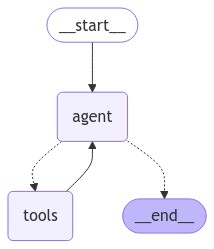

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Results

In [15]:
import pprint

input_prompt = """You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.
Use the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.

Your proposal should include:
1. Executive Summary
2. Company Overview (Bausch Health)
3. Product Description
4. Market Analysis
5. Marketing Strategy
6. Financial Projections
   - Include estimated production costs
   - Projected sales and revenue
7. Conclusion

Ensure your proposal is well-structured, informative, and persuasive.
"""

# Run the graph
final_state = graph.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

In [17]:
print(final_state["messages"][-1].content)

### Proposal for a New Weight Loss Drug to Bausch Health

---

#### 1. Executive Summary

This proposal outlines the development and market introduction of a new weight loss drug by Bausch Health. The drug aims to address the growing obesity epidemic by offering a safe, effective, and innovative solution. This document provides a comprehensive overview of Bausch Health, a detailed product description, market analysis, marketing strategy, and financial projections to ensure the successful launch and sustained growth of the new weight loss drug.

---

#### 2. Company Overview (Bausch Health)

**Bausch Health Companies Inc.** is a global, diversified pharmaceutical company dedicated to improving people's lives through its innovative health solutions. The company operates in various therapeutic areas, including gastroenterology, hepatology, neurology, dermatology, and eye health. Bausch Health develops, manufactures, and markets a wide range of products, including prescription medications,